In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [122]:

# 1. Hyperparameters
batch_size = 64
epochs = 100
learning_rate = 0.001


In [123]:

# 2. Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.5 * torch.randn_like(x)),  # Add Gaussian noise
    transforms.Lambda(lambda x: torch.clamp(x, 0., 1.))         # Clamp values between 0 and 1
])


In [124]:

clean_transform = transforms.ToTensor()


In [125]:

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [126]:

clean_train_dataset = datasets.MNIST(root='./data', train=True, transform=clean_transform, download=True)
clean_test_dataset = datasets.MNIST(root='./data', train=False, transform=clean_transform, download=True)


In [127]:

train_loader = DataLoader(list(zip(train_dataset, clean_train_dataset)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_dataset, clean_test_dataset)), batch_size=batch_size, shuffle=False)


In [128]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7 -> 4x4
            nn.ReLU()
        )
        # Decoder 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),  # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [129]:

# 4. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [130]:

# 5. Training Loop with Improved Logs and Saving
def train(model, loader, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (noisy, clean) in enumerate(loader):
        noisy, clean = noisy[0].to(device), clean[0].to(device)  # Extract noisy and clean images
        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Print batch progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}], Batch [{batch_idx}/{len(loader)}], Loss: {loss.item():.4f}")
    return total_loss / len(loader)



In [131]:

# 6. Testing Loop with Visualization
def test(model, loader, epoch):
    model.eval()
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy[0].to(device), clean[0].to(device)
            outputs = model(noisy)

            # Visualize the results
            plt.figure(figsize=(9, 6))
            for i in range(5):  # Show first 5 images
                plt.subplot(5, 3, i * 3 + 1)
                plt.imshow(noisy[i].cpu().squeeze(0), cmap='gray')
                plt.title("Noisy")
                plt.axis('off')
                plt.subplot(5, 3, i * 3 + 2)
                plt.imshow(clean[i].cpu().squeeze(0), cmap='gray')
                plt.title("Original")
                plt.axis('off')
                plt.subplot(5, 3, i * 3 + 3)
                plt.imshow(outputs[i].cpu().squeeze(0), cmap='gray')
                plt.title("Denoised")
                plt.axis('off')

            plt.suptitle(f"Epoch {epoch} Results")
            plt.tight_layout()
            plt.show()
            break  # Visualize only the first batch


In [132]:

# 7. Save Model Checkpoints
def save_model(model, path="autoencoder.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


In [133]:

# 8. Load Model Checkpoints (optional)
def load_model(model, path="autoencoder.pth"):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")


Epoch [1], Batch [0/938], Loss: 0.1793
Epoch [1], Batch [100/938], Loss: 0.1080
Epoch [1], Batch [200/938], Loss: 0.0562
Epoch [1], Batch [300/938], Loss: 0.0300
Epoch [1], Batch [400/938], Loss: 0.0236
Epoch [1], Batch [500/938], Loss: 0.0203
Epoch [1], Batch [600/938], Loss: 0.0171
Epoch [1], Batch [700/938], Loss: 0.0178
Epoch [1], Batch [800/938], Loss: 0.0163
Epoch [1], Batch [900/938], Loss: 0.0148
Epoch [2], Batch [0/938], Loss: 0.0152
Epoch [2], Batch [100/938], Loss: 0.0147
Epoch [2], Batch [200/938], Loss: 0.0134
Epoch [2], Batch [300/938], Loss: 0.0133
Epoch [2], Batch [400/938], Loss: 0.0138
Epoch [2], Batch [500/938], Loss: 0.0144
Epoch [2], Batch [600/938], Loss: 0.0125
Epoch [2], Batch [700/938], Loss: 0.0149
Epoch [2], Batch [800/938], Loss: 0.0138
Epoch [2], Batch [900/938], Loss: 0.0134
Epoch [3], Batch [0/938], Loss: 0.0135
Epoch [3], Batch [100/938], Loss: 0.0130
Epoch [3], Batch [200/938], Loss: 0.0131
Epoch [3], Batch [300/938], Loss: 0.0130
Epoch [3], Batch [400/

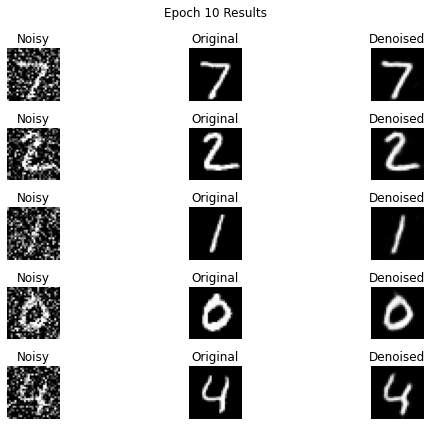

Epoch [11], Batch [0/938], Loss: 0.0114
Epoch [11], Batch [100/938], Loss: 0.0108
Epoch [11], Batch [200/938], Loss: 0.0108
Epoch [11], Batch [300/938], Loss: 0.0113
Epoch [11], Batch [400/938], Loss: 0.0122
Epoch [11], Batch [500/938], Loss: 0.0116
Epoch [11], Batch [600/938], Loss: 0.0109
Epoch [11], Batch [700/938], Loss: 0.0109
Epoch [11], Batch [800/938], Loss: 0.0111
Epoch [11], Batch [900/938], Loss: 0.0115
Epoch [12], Batch [0/938], Loss: 0.0108
Epoch [12], Batch [100/938], Loss: 0.0119
Epoch [12], Batch [200/938], Loss: 0.0107
Epoch [12], Batch [300/938], Loss: 0.0105
Epoch [12], Batch [400/938], Loss: 0.0105
Epoch [12], Batch [500/938], Loss: 0.0117
Epoch [12], Batch [600/938], Loss: 0.0111
Epoch [12], Batch [700/938], Loss: 0.0103
Epoch [12], Batch [800/938], Loss: 0.0116
Epoch [12], Batch [900/938], Loss: 0.0110
Epoch [13], Batch [0/938], Loss: 0.0112
Epoch [13], Batch [100/938], Loss: 0.0107
Epoch [13], Batch [200/938], Loss: 0.0115
Epoch [13], Batch [300/938], Loss: 0.010

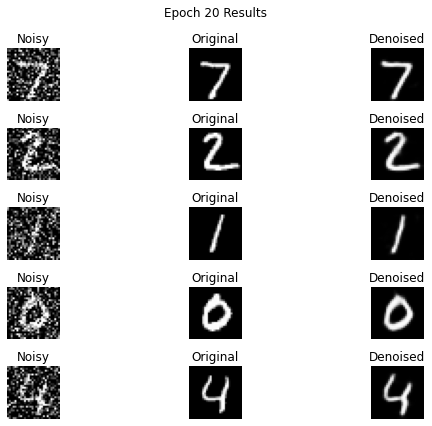

Model saved to autoencoder_epoch_20.pth
Epoch [21], Batch [0/938], Loss: 0.0110
Epoch [21], Batch [100/938], Loss: 0.0105
Epoch [21], Batch [200/938], Loss: 0.0103
Epoch [21], Batch [300/938], Loss: 0.0101
Epoch [21], Batch [400/938], Loss: 0.0105
Epoch [21], Batch [500/938], Loss: 0.0103
Epoch [21], Batch [600/938], Loss: 0.0102
Epoch [21], Batch [700/938], Loss: 0.0105
Epoch [21], Batch [800/938], Loss: 0.0102
Epoch [21], Batch [900/938], Loss: 0.0104
Epoch [22], Batch [0/938], Loss: 0.0105
Epoch [22], Batch [100/938], Loss: 0.0101
Epoch [22], Batch [200/938], Loss: 0.0102
Epoch [22], Batch [300/938], Loss: 0.0105
Epoch [22], Batch [400/938], Loss: 0.0100
Epoch [22], Batch [500/938], Loss: 0.0109
Epoch [22], Batch [600/938], Loss: 0.0110
Epoch [22], Batch [700/938], Loss: 0.0106
Epoch [22], Batch [800/938], Loss: 0.0110
Epoch [22], Batch [900/938], Loss: 0.0105
Epoch [23], Batch [0/938], Loss: 0.0101
Epoch [23], Batch [100/938], Loss: 0.0100
Epoch [23], Batch [200/938], Loss: 0.0107


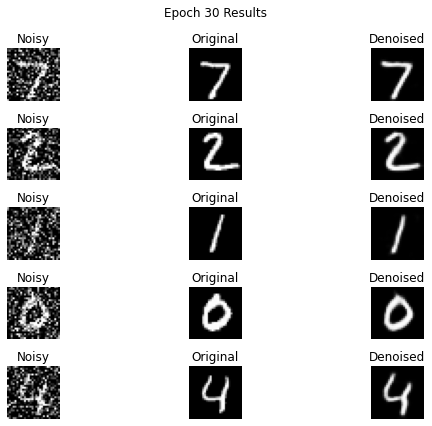

Epoch [31], Batch [0/938], Loss: 0.0096
Epoch [31], Batch [100/938], Loss: 0.0101
Epoch [31], Batch [200/938], Loss: 0.0095
Epoch [31], Batch [300/938], Loss: 0.0099
Epoch [31], Batch [400/938], Loss: 0.0093
Epoch [31], Batch [500/938], Loss: 0.0099
Epoch [31], Batch [600/938], Loss: 0.0102
Epoch [31], Batch [700/938], Loss: 0.0108
Epoch [31], Batch [800/938], Loss: 0.0104
Epoch [31], Batch [900/938], Loss: 0.0107
Epoch [32], Batch [0/938], Loss: 0.0111
Epoch [32], Batch [100/938], Loss: 0.0109
Epoch [32], Batch [200/938], Loss: 0.0099
Epoch [32], Batch [300/938], Loss: 0.0108
Epoch [32], Batch [400/938], Loss: 0.0111
Epoch [32], Batch [500/938], Loss: 0.0107
Epoch [32], Batch [600/938], Loss: 0.0095
Epoch [32], Batch [700/938], Loss: 0.0096
Epoch [32], Batch [800/938], Loss: 0.0099
Epoch [32], Batch [900/938], Loss: 0.0103
Epoch [33], Batch [0/938], Loss: 0.0106
Epoch [33], Batch [100/938], Loss: 0.0105
Epoch [33], Batch [200/938], Loss: 0.0097
Epoch [33], Batch [300/938], Loss: 0.010

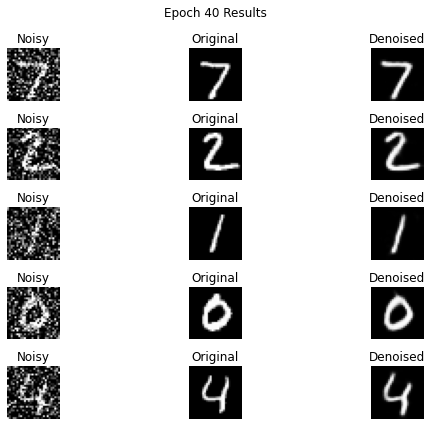

Model saved to autoencoder_epoch_40.pth
Epoch [41], Batch [0/938], Loss: 0.0099
Epoch [41], Batch [100/938], Loss: 0.0098
Epoch [41], Batch [200/938], Loss: 0.0100
Epoch [41], Batch [300/938], Loss: 0.0096
Epoch [41], Batch [400/938], Loss: 0.0104
Epoch [41], Batch [500/938], Loss: 0.0110
Epoch [41], Batch [600/938], Loss: 0.0101
Epoch [41], Batch [700/938], Loss: 0.0095
Epoch [41], Batch [800/938], Loss: 0.0106
Epoch [41], Batch [900/938], Loss: 0.0110
Epoch [42], Batch [0/938], Loss: 0.0097
Epoch [42], Batch [100/938], Loss: 0.0108
Epoch [42], Batch [200/938], Loss: 0.0095
Epoch [42], Batch [300/938], Loss: 0.0098
Epoch [42], Batch [400/938], Loss: 0.0106
Epoch [42], Batch [500/938], Loss: 0.0101
Epoch [42], Batch [600/938], Loss: 0.0106
Epoch [42], Batch [700/938], Loss: 0.0107
Epoch [42], Batch [800/938], Loss: 0.0099
Epoch [42], Batch [900/938], Loss: 0.0102
Epoch [43], Batch [0/938], Loss: 0.0101
Epoch [43], Batch [100/938], Loss: 0.0095
Epoch [43], Batch [200/938], Loss: 0.0106


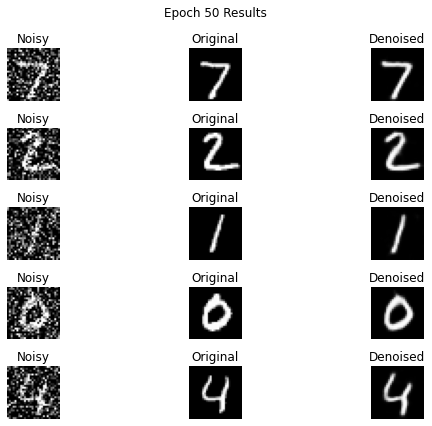

Epoch [51], Batch [0/938], Loss: 0.0107
Epoch [51], Batch [100/938], Loss: 0.0092
Epoch [51], Batch [200/938], Loss: 0.0104
Epoch [51], Batch [300/938], Loss: 0.0099
Epoch [51], Batch [400/938], Loss: 0.0101
Epoch [51], Batch [500/938], Loss: 0.0109
Epoch [51], Batch [600/938], Loss: 0.0098
Epoch [51], Batch [700/938], Loss: 0.0100
Epoch [51], Batch [800/938], Loss: 0.0104
Epoch [51], Batch [900/938], Loss: 0.0096
Epoch [52], Batch [0/938], Loss: 0.0096
Epoch [52], Batch [100/938], Loss: 0.0103
Epoch [52], Batch [200/938], Loss: 0.0107
Epoch [52], Batch [300/938], Loss: 0.0100
Epoch [52], Batch [400/938], Loss: 0.0099
Epoch [52], Batch [500/938], Loss: 0.0109
Epoch [52], Batch [600/938], Loss: 0.0105
Epoch [52], Batch [700/938], Loss: 0.0100
Epoch [52], Batch [800/938], Loss: 0.0100
Epoch [52], Batch [900/938], Loss: 0.0108
Epoch [53], Batch [0/938], Loss: 0.0095
Epoch [53], Batch [100/938], Loss: 0.0096
Epoch [53], Batch [200/938], Loss: 0.0106
Epoch [53], Batch [300/938], Loss: 0.010

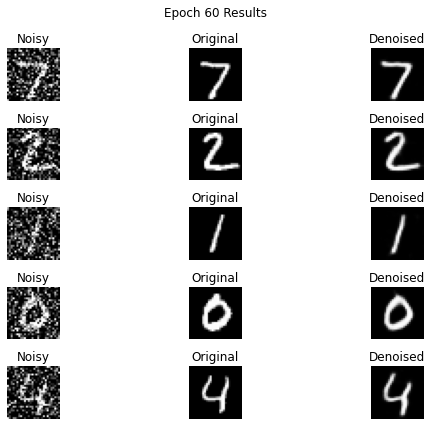

Model saved to autoencoder_epoch_60.pth
Epoch [61], Batch [0/938], Loss: 0.0100
Epoch [61], Batch [100/938], Loss: 0.0098
Epoch [61], Batch [200/938], Loss: 0.0098
Epoch [61], Batch [300/938], Loss: 0.0103
Epoch [61], Batch [400/938], Loss: 0.0106
Epoch [61], Batch [500/938], Loss: 0.0104
Epoch [61], Batch [600/938], Loss: 0.0100
Epoch [61], Batch [700/938], Loss: 0.0104
Epoch [61], Batch [800/938], Loss: 0.0094
Epoch [61], Batch [900/938], Loss: 0.0101
Epoch [62], Batch [0/938], Loss: 0.0096
Epoch [62], Batch [100/938], Loss: 0.0092
Epoch [62], Batch [200/938], Loss: 0.0086
Epoch [62], Batch [300/938], Loss: 0.0107
Epoch [62], Batch [400/938], Loss: 0.0100
Epoch [62], Batch [500/938], Loss: 0.0103
Epoch [62], Batch [600/938], Loss: 0.0090
Epoch [62], Batch [700/938], Loss: 0.0094
Epoch [62], Batch [800/938], Loss: 0.0098
Epoch [62], Batch [900/938], Loss: 0.0105
Epoch [63], Batch [0/938], Loss: 0.0102
Epoch [63], Batch [100/938], Loss: 0.0103
Epoch [63], Batch [200/938], Loss: 0.0100


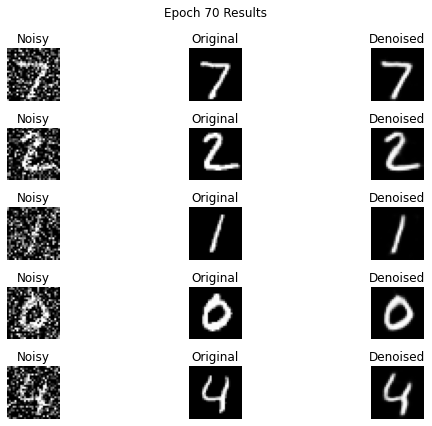

Epoch [71], Batch [0/938], Loss: 0.0100
Epoch [71], Batch [100/938], Loss: 0.0093
Epoch [71], Batch [200/938], Loss: 0.0096
Epoch [71], Batch [300/938], Loss: 0.0111
Epoch [71], Batch [400/938], Loss: 0.0101
Epoch [71], Batch [500/938], Loss: 0.0102
Epoch [71], Batch [600/938], Loss: 0.0096
Epoch [71], Batch [700/938], Loss: 0.0100
Epoch [71], Batch [800/938], Loss: 0.0104
Epoch [71], Batch [900/938], Loss: 0.0103
Epoch [72], Batch [0/938], Loss: 0.0101
Epoch [72], Batch [100/938], Loss: 0.0104
Epoch [72], Batch [200/938], Loss: 0.0098
Epoch [72], Batch [300/938], Loss: 0.0103
Epoch [72], Batch [400/938], Loss: 0.0106
Epoch [72], Batch [500/938], Loss: 0.0096
Epoch [72], Batch [600/938], Loss: 0.0096
Epoch [72], Batch [700/938], Loss: 0.0103
Epoch [72], Batch [800/938], Loss: 0.0107
Epoch [72], Batch [900/938], Loss: 0.0101
Epoch [73], Batch [0/938], Loss: 0.0101
Epoch [73], Batch [100/938], Loss: 0.0108
Epoch [73], Batch [200/938], Loss: 0.0100
Epoch [73], Batch [300/938], Loss: 0.009

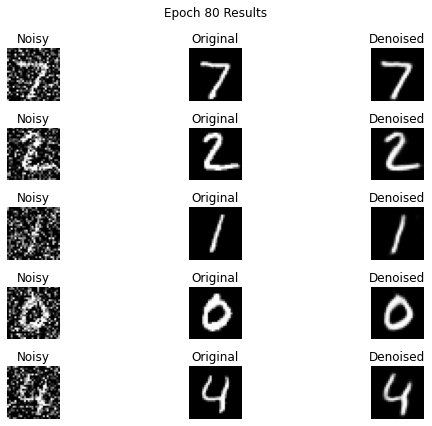

Model saved to autoencoder_epoch_80.pth
Epoch [81], Batch [0/938], Loss: 0.0090
Epoch [81], Batch [100/938], Loss: 0.0100
Epoch [81], Batch [200/938], Loss: 0.0094
Epoch [81], Batch [300/938], Loss: 0.0098
Epoch [81], Batch [400/938], Loss: 0.0096
Epoch [81], Batch [500/938], Loss: 0.0098
Epoch [81], Batch [600/938], Loss: 0.0099
Epoch [81], Batch [700/938], Loss: 0.0093
Epoch [81], Batch [800/938], Loss: 0.0107
Epoch [81], Batch [900/938], Loss: 0.0102
Epoch [82], Batch [0/938], Loss: 0.0096
Epoch [82], Batch [100/938], Loss: 0.0110
Epoch [82], Batch [200/938], Loss: 0.0098
Epoch [82], Batch [300/938], Loss: 0.0105
Epoch [82], Batch [400/938], Loss: 0.0108
Epoch [82], Batch [500/938], Loss: 0.0093
Epoch [82], Batch [600/938], Loss: 0.0098
Epoch [82], Batch [700/938], Loss: 0.0099
Epoch [82], Batch [800/938], Loss: 0.0104
Epoch [82], Batch [900/938], Loss: 0.0103
Epoch [83], Batch [0/938], Loss: 0.0097
Epoch [83], Batch [100/938], Loss: 0.0094
Epoch [83], Batch [200/938], Loss: 0.0108


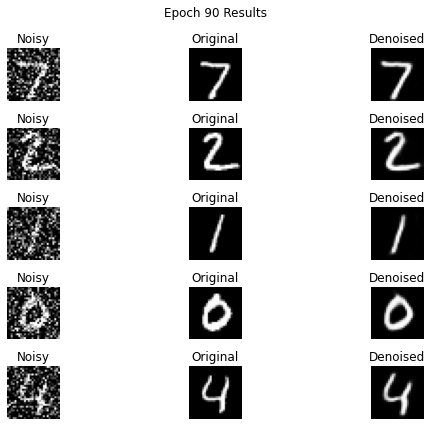

Epoch [91], Batch [0/938], Loss: 0.0102
Epoch [91], Batch [100/938], Loss: 0.0100
Epoch [91], Batch [200/938], Loss: 0.0092
Epoch [91], Batch [300/938], Loss: 0.0097
Epoch [91], Batch [400/938], Loss: 0.0104
Epoch [91], Batch [500/938], Loss: 0.0097
Epoch [91], Batch [600/938], Loss: 0.0105
Epoch [91], Batch [700/938], Loss: 0.0097
Epoch [91], Batch [800/938], Loss: 0.0095
Epoch [91], Batch [900/938], Loss: 0.0110
Epoch [92], Batch [0/938], Loss: 0.0106
Epoch [92], Batch [100/938], Loss: 0.0101
Epoch [92], Batch [200/938], Loss: 0.0094
Epoch [92], Batch [300/938], Loss: 0.0105
Epoch [92], Batch [400/938], Loss: 0.0096
Epoch [92], Batch [500/938], Loss: 0.0103
Epoch [92], Batch [600/938], Loss: 0.0093
Epoch [92], Batch [700/938], Loss: 0.0092
Epoch [92], Batch [800/938], Loss: 0.0094
Epoch [92], Batch [900/938], Loss: 0.0098
Epoch [93], Batch [0/938], Loss: 0.0099
Epoch [93], Batch [100/938], Loss: 0.0094
Epoch [93], Batch [200/938], Loss: 0.0107
Epoch [93], Batch [300/938], Loss: 0.009

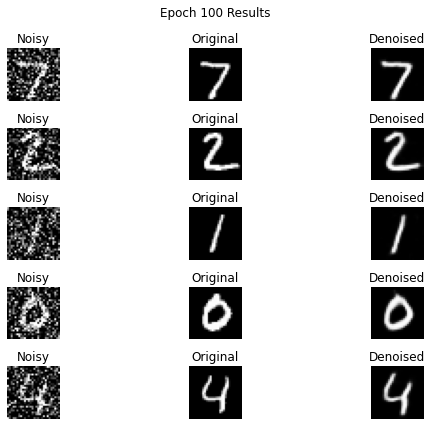

Model saved to autoencoder_epoch_100.pth
Model saved to autoencoder_final.pth


In [134]:

# 9. Main Execution with Training, Testing, and Saving
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, epoch)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs}, Average Loss: {train_loss:.4f}")
    
    # Test and visualize every 2 epochs
    if epoch % 10 == 0:
        test(model, test_loader, epoch)
    
    # Save model after each epoch
    if epoch % 20 == 0:
        save_model(model, path=f"autoencoder_epoch_{epoch}.pth")

# Final Save
save_model(model, path="autoencoder_final.pth")
